In [1]:
import pickle
import numpy as np
from scipy.sparse import csr_matrix
import pandas as pd
from scipy.linalg import svd
import matplotlib.pyplot as plt
from utils import *

test = pd.read_csv("data/activity_test_blanked.csv", header=None)
test.columns = ["uniprot_id", "mol_id", "activity"]
test["mol_id"] = test["mol_id"].str.strip()

train = pd.read_csv("data/activity_train.csv", header=None)
train.columns = ["uniprot_id", "mol_id", "activity"]
train["mol_id"] = train["mol_id"].str.strip()


with open("data/mol_bits.pkl", "rb") as f:
    mol_bits = pickle.load(f)

with open("data/results/buckets.pkl", "rb") as f:
    buckets = pickle.load(f)

mol_ids = list(mol_bits.keys())
prot_ids = list(train["uniprot_id"].unique())

## Preprocessing the data into train / validation set


In [2]:
orig_prot, orig_mol = train.pivot(
    index="uniprot_id", columns="mol_id", values="activity"
).shape
orig_prot, orig_mol

(144, 72632)

In [3]:
Full_table = train.pivot(
    index="uniprot_id", columns="mol_id", values="activity"
).fillna(0)

In [4]:
# subsetting for validation

prots = 120
molecules = 60_000

subset = (
    Full_table.iloc[prots:, molecules:]
    .reset_index()
    .melt(id_vars="uniprot_id", value_name="activity")
)
subset = subset[subset["activity"] != 0]
subset["activity"] = subset["activity"].astype(int)

# reno
train = (
    train.set_index(["uniprot_id", "mol_id"])
    .drop(subset.set_index(["uniprot_id", "mol_id"]).index)
    .reset_index()
)

In [25]:
subset

,uniprot_id,mol_id,activity
520,Q9H3N8,CHEMBL461360,1
640,Q9H3N8,CHEMBL461535,1
664,Q9H3N8,CHEMBL461536,1
688,Q9H3N8,CHEMBL461537,5
717,Q9Y5N1,CHEMBL461550,4
...,...,...,...
294817,Q14416,CHEMBL94990,1
295587,Q15722,CHEMBL95453,10
295941,Q9Y5N1,CHEMBL95645,10
295968,Q14289,CHEMBL95692,1


In [28]:
train[(train["uniprot_id"] == "Q9H3N8") & (train["mol_id"] == "CHEMBL461360")]

,uniprot_id,mol_id,activity


### Train and Validation 

In [5]:
print(train.pivot(index="uniprot_id", columns="mol_id", values="activity").shape)
print(subset.pivot(index="uniprot_id", columns="mol_id", values="activity").shape)

(144, 70941)
(23, 1939)


## Latent Factors
- Transform Prots x Molecules matrix into a product of 2 matrices
$$ R = Q \times P^T $$
- SVD ------> $R = U \sum V^T$
    - $P = U$ 
    - $Q = \sum \times V^T$

In [6]:
Train_pivot = train.pivot(
    index="uniprot_id", columns="mol_id", values="activity"
).fillna(0)
Train_pivot

mol_id,CHEMBL10,CHEMBL1000,CHEMBL100003,CHEMBL100004,CHEMBL100045,CHEMBL100052,CHEMBL10007,CHEMBL100071,CHEMBL10009,CHEMBL100104,...,CHEMBL99939,CHEMBL99967,CHEMBL9997,CHEMBL99979,CHEMBL9998,CHEMBL99982,CHEMBL99983,CHEMBL99987,CHEMBL9999,CHEMBL99994
uniprot_id,,,,,,,,,,,,,,,,,,,,,
O14842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
O43193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
O43613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
O43614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
O95665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9UBY5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q9UKP6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q9Y5N1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
## SVD on full_table

U, S, V = svd(Train_pivot, full_matrices=False)


def get_factors(U, S, Vt, k=10):
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    Vt_k = Vt[:k, :]
    P = U_k.copy()
    Q = (S_k @ Vt_k).T
    return P, Q


def masked_MSE(R, R_hat):
    mask = (R > 0) * 1
    return np.sum((mask * (R - R_hat)) ** 2) / np.sum(mask)


P, Q = get_factors(U, S, V, k=128)
P.shape, Q.shape

((144, 128), (70941, 128))

In [8]:
np.argwhere(Train_pivot.values > 0)

array([[    0,  8644],
       [    0,  8646],
       [    0,  8647],
       ...,
       [  143, 55072],
       [  143, 55447],
       [  143, 56062]])

In [9]:
print(Train_pivot.values[0, 8644])
P[0] @ Q[8644]

1.0


1.0

In [10]:
subset

,uniprot_id,mol_id,activity
520,Q9H3N8,CHEMBL461360,1
640,Q9H3N8,CHEMBL461535,1
664,Q9H3N8,CHEMBL461536,1
688,Q9H3N8,CHEMBL461537,5
717,Q9Y5N1,CHEMBL461550,4
...,...,...,...
294817,Q14416,CHEMBL94990,1
295587,Q15722,CHEMBL95453,10
295941,Q9Y5N1,CHEMBL95645,10
295968,Q14289,CHEMBL95692,1


In [11]:
test_ids = list(subset["mol_id"].unique()) + list(train["mol_id"].unique())
test_ids = set(test_ids)

i = 200
print(subset.iloc[i])
print()
print(
    prot_ids.index(subset.iloc[i]["uniprot_id"]),
    mol_ids.index(subset.iloc[i]["mol_id"]),
)

print("Molecule in train: ", subset.iloc[i]["mol_id"] in Train_pivot.columns)
neighs = k_neighbors(
    mol_idx=mol_ids.index(subset.iloc[i]["mol_id"]),
    buckets=buckets,
    mol_bits=mol_bits,
    mol_ids=mol_ids,
    test_ids=test_ids,
    k=3,
)
print(neighs)
print(
    "Neighs in train: ",
    any(mol_ids[neighs[j][0]] in Train_pivot.columns for j in range(len(neighs))),
)
mol_ids[neighs[2][0]] in Train_pivot.columns

uniprot_id           Q9H3N8
mol_id        CHEMBL4758983
activity                  1
Name: 39784, dtype: object

136 69368
Molecule in train:  False
[(69359, 0.71875), (69367, 0.6190476190476191), (17457, 0.2898550724637681)]
Neighs in train:  True


True

## Stochastic Gradient Descent - Non-regularized


- Objective function: 
$$ \min_{P,Q} \sum(r_{ui} - q_i.p^T_u) ^2 $$

- Update rules:
$$ P_t = P_{t-1} - \eta\nabla P $$


$$ Q_t = Q_{t-1} - \eta\nabla Q $$


$$ \Delta_{ui} = 2(r_{ui} - q_i.p^T_u) $$


$$ p_u = p_u + \eta \Delta_{ui} q_i  $$
$$ q_i = q_i + \eta \Delta_{ui} p_u $$


In [12]:
## SVD on full_table

U, S, V = svd(Train_pivot, full_matrices=False)


def get_factors(U, S, V, k=10):
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    V_k = V[:k, :]
    P = U_k.copy()
    Q = S_k @ V_k
    return P, Q


def masked_MSE(R, R_hat):
    mask = (R > 0) * 1
    return np.sum((mask * (R - R_hat)) ** 2) / np.sum(mask)


P, Q = get_factors(U, S, V, k=128)
P.shape, Q.shape

((144, 128), (128, 70941))

In [40]:
### doing SGD ###

U, S, V = svd(Full_table, full_matrices=False)
P, Q = get_factors(U, S, V, k=40)

mses = []

for k in range(2, 129, 2):
    P, Q = get_factors(U, S, V, k=k)
    mses.append(masked_MSE(Full_table.values, P @ Q.T))

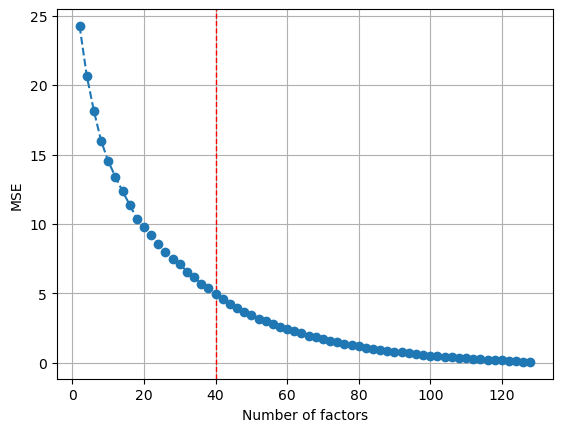

In [51]:
# plt.axvline(40, linestyle="--", color="red", linewidth=1)
plt.plot(range(2, 129, 2), mses, "--o")
plt.xlabel("Number of factors")
plt.ylabel("MSE")
plt.grid()
plt.show()

In [13]:
locations = np.argwhere(Full_table.values > 0)

In [14]:
print(P.shape, Q.shape)
locations

(144, 128) (128, 70941)


array([[    0,  8644],
       [    0,  8646],
       [    0,  8647],
       ...,
       [  143, 69686],
       [  143, 69736],
       [  143, 69776]])

In [15]:
locations

array([[    0,  8644],
       [    0,  8646],
       [    0,  8647],
       ...,
       [  143, 69686],
       [  143, 69736],
       [  143, 69776]])

In [21]:
Full_table.values[0, 8644]

1.0

In [20]:
P[0] @ Q.T[8644]

1.0

In [149]:
U, S, V = svd(Full_table, full_matrices=False)
P, Q = get_factors(U, S, V, k=60)
locations = np.argwhere(Full_table.values > 0)
R = Full_table.values


def epoch(positions, R, P, Q, seed=42, LR=0.0001):
    np.random.seed(seed)
    np.random.shuffle(positions)
    for pos in positions:
        R_ui = R[pos[0], pos[1]]
        delta = 2 * (R_ui - P[pos[0], :] @ Q[:, pos[1]])
        Q[:, pos[1]] += LR * delta * P[pos[0], :]
        P[pos[0], :] += LR * delta * Q[:, pos[1]]
    return P, Q


def SGD(R, epochs=10, k=10, seed=42, LR=0.001):
    U, S, V = svd(R, full_matrices=False)
    P, Q = get_factors(U, S, V, k=k)
    locations = np.argwhere(R > 0)
    mses = []
    for _ in range(epochs):
        P, Q = epoch(locations, R, P, Q, seed=seed, LR=LR)
        mses.append(masked_MSE(R, P @ Q))
    return P, Q, mses


P, Q, mses = SGD(R, epochs=10, k=60, seed=42, LR=0.001)

In [164]:
P, Q, mses1 = SGD(R, epochs=200, k=60, seed=42, LR=0.00001)
P, Q, mses2 = SGD(R, epochs=200, k=60, seed=42, LR=0.0001)
P, Q, mses3 = SGD(R, epochs=200, k=60, seed=42, LR=0.001)

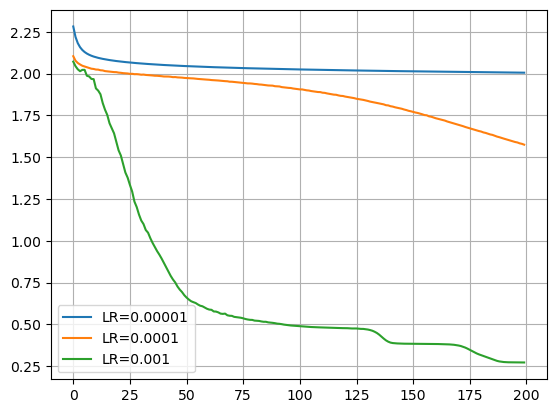

In [165]:
plt.plot(mses1, label="LR=0.00001")
plt.plot(mses2, label="LR=0.0001")
plt.plot(mses3, label="LR=0.001")
plt.legend()
plt.grid()
plt.show()

### Regularized Stochastic Gradient Descent

Objective with penalization:

$$ \min_{P,Q} \sum(r_{ui} - q_i.p^T_u) ^2 + \lambda\left[ \sum_u||p_u|| + \sum_i||q_i|| \right]$$

Update rules:

$$ \nabla Q_{ik} = \sum\left(-2(r_{ui} - q_i.p^T_u)p_{uk} + 2\lambda_q q_{ik} \right) $$

$$ \nabla P_{uk} = \sum\left(-2(r_{ui} - q_i.p^T_u)q_{ik} + 2\lambda_p p_{uk} \right) $$




In [169]:
P.shape, Q.shape, R.shape

((144, 60), (60, 72632), (144, 72632))

In [171]:
def Reg_Epoch(positions, R, P, Q, seed=42, LR=0.0001, Lp=1, Lq=1):
    np.random.seed(seed)
    np.random.shuffle(positions)
    for pos in positions:
        R_ui = R[pos[0], pos[1]]
        delta = 2 * (R_ui - P[pos[0], :] @ Q[:, pos[1]])
        Q[:, pos[1]] += LR * (delta * P[pos[0], :] - Lq * Q[:, pos[1]])
        P[pos[0], :] += LR * (delta * Q[:, pos[1]] - Lp * P[pos[0], :])
    return P, Q


def Reg_SGD(R, epochs=10, k=10, seed=42, LR=0.001, Lp=1, Lq=1):
    U, S, V = svd(R, full_matrices=False)
    P, Q = get_factors(U, S, V, k=k)
    locations = np.argwhere(R > 0)
    mses = []
    for _ in range(epochs):
        P, Q = Reg_Epoch(locations, R, P, Q, seed=seed, LR=LR, Lp=Lp, Lq=Lq)
        mses.append(masked_MSE(R, P @ Q))
    return P, Q, mses


P, Q, mses = Reg_SGD(R, epochs=10, k=60, seed=42, LR=0.001, Lp=1, Lq=1)

In [176]:
P, Q, msesL1 = Reg_SGD(R, epochs=150, k=60, seed=42, LR=0.001, Lp=0.1, Lq=0.1)
P, Q, msesL2 = Reg_SGD(R, epochs=150, k=60, seed=42, LR=0.001, Lp=0.01, Lq=0.01)
P, Q, msesL3 = Reg_SGD(R, epochs=150, k=60, seed=42, LR=0.001, Lp=0.001, Lq=0.001)

In [185]:
P, Q, msesL4 = Reg_SGD(R, epochs=150, k=60, seed=42, LR=0.001, Lp=1, Lq=1)
P, Q, msesL5 = Reg_SGD(R, epochs=150, k=60, seed=42, LR=0.001, Lp=2, Lq=2)

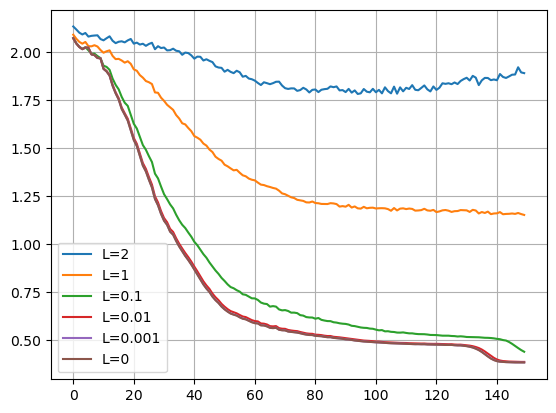

In [187]:
plt.plot(msesL5, label="L=2")
plt.plot(msesL4, label="L=1")
plt.plot(msesL1, label="L=0.1")
plt.plot(msesL2, label="L=0.01")
plt.plot(msesL3, label="L=0.001")
plt.plot(mses1, label="L=0")
plt.legend()
plt.grid()
plt.show()

In [189]:
pd.DataFrame(
    {
        "L=2": msesL5,
        "L=1": msesL4,
        "L=0.1": msesL1,
        "L=0.01": msesL2,
        "L=0.001": msesL3,
        "L=0": mses1,
    }
).to_csv("data/results/Reg_SGD.csv", index=False)

In [190]:
Lps = [0, 0.001, 0.01, 0.1, 1, 2]
Lqs = [0, 0.001, 0.01, 0.1, 1, 2]

results = {}
for Lp in Lps:
    for Lq in Lqs:
        P, Q, mses = Reg_SGD(R, epochs=150, k=60, seed=42, LR=0.001, Lp=Lp, Lq=Lq)
        results[(Lp, Lq)] = mses

In [191]:
with open("data/results/Reg_SGD_LCombs.pkl", "wb") as f:
    pickle.dump(results, f)

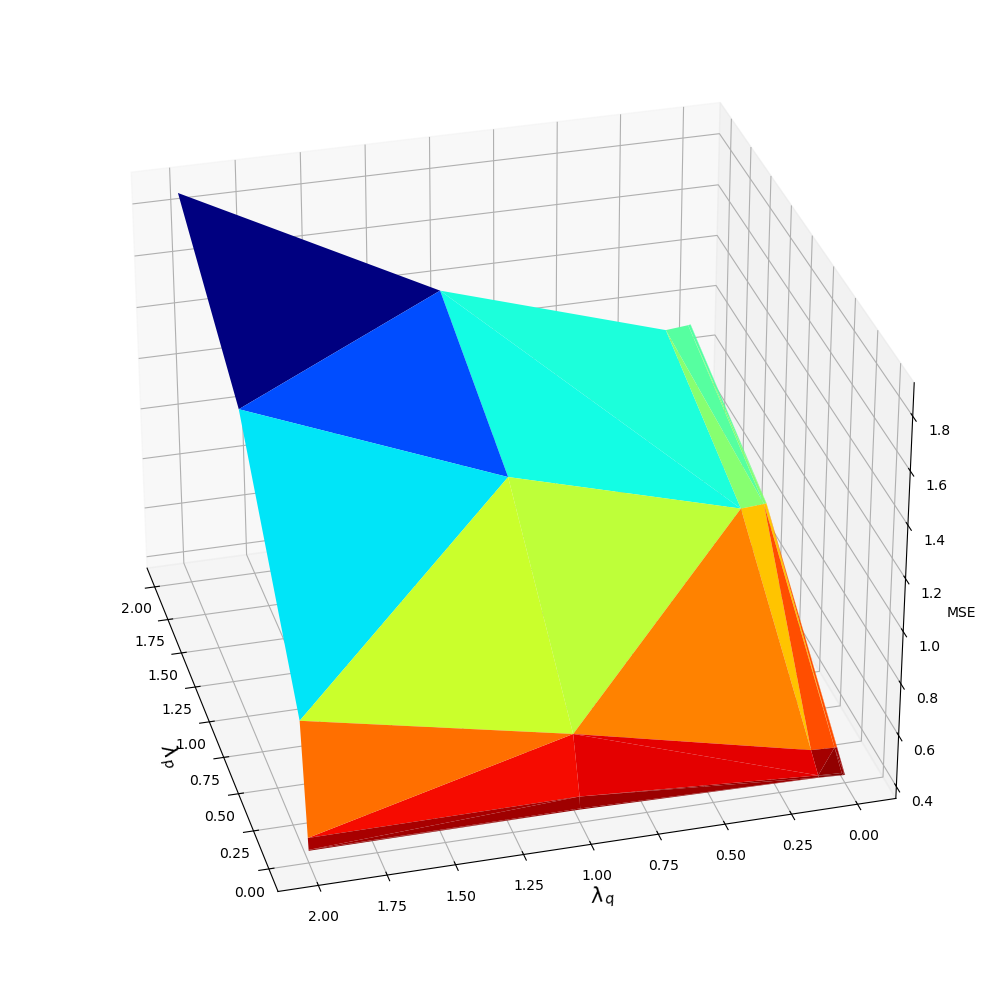

In [251]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 100

# Normalize mses[-1] values
mses_values = [mses[-1] for mses in results.values()]
scaler = MinMaxScaler()
mses_norm = scaler.fit_transform(np.array(mses_values).reshape(-1, 1))

# Flatten mses_norm to make it 1D
mses_norm = mses_norm.flatten()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

# Create a scatter plot
sc = ax.plot_trisurf(
    [Lp for ((Lp, Lq), mses) in results.items()],
    [Lq for ((Lp, Lq), mses) in results.items()],
    mses_values,
    # c=mses_norm,
    cmap="jet_r",
    linewidth=0.01,
)

ax.view_init(30, 165)
# ax.view_init(30, 220)
ax.set_xlabel("$\lambda_p$", rotation=90, fontsize=15)
ax.set_ylabel("$\lambda_q$", rotation=90, fontsize=15)
ax.set_zlabel("MSE")
plt.tight_layout()
plt.savefig("data/figs/Reg_SGD_LCombs.png")
plt.show()

In [227]:
L = 0.1

P, Q, mses_20 = Reg_SGD(R, epochs=150, k=20, seed=42, LR=0.001, Lp=L, Lq=L)
P, Q, mses_40 = Reg_SGD(R, epochs=150, k=40, seed=42, LR=0.001, Lp=L, Lq=L)
P, Q, mses_60 = Reg_SGD(R, epochs=150, k=60, seed=42, LR=0.001, Lp=L, Lq=L)

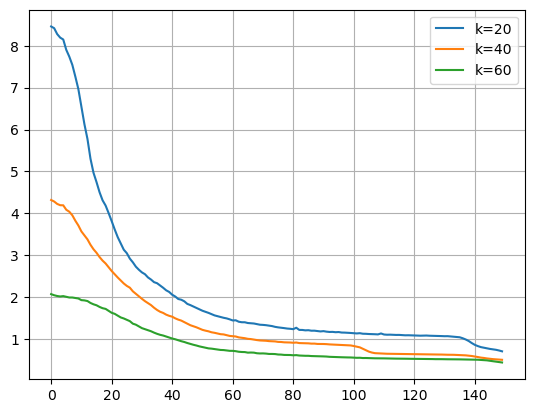

In [230]:
plt.plot(mses_20, label="k=20")
plt.plot(mses_40, label="k=40")
plt.plot(mses_60, label="k=60")
plt.legend()
plt.grid()

In [231]:
pd.DataFrame({"k=20": mses_20, "k=40": mses_40, "k=60": mses_60}).to_csv(
    "data/results/Reg_SGD_kCombs.csv", index=False
)

In [232]:
K = 60
L = 0.1

P, Q, mses_final = Reg_SGD(R, epochs=150, k=K, seed=42, LR=0.001, Lp=L, Lq=L)